# Анализ моделей эмбеддингов

План анализа:
1. Визуализация в 2d при помощи UMAP
2. Далее переходим к подсчёту косинусного расстояния: считаем распределение внутри каждого кластера и распределение между кластерами. Виузализируем распределения на одном графике, чтобы оценить пересечение (оверлей)
3. Для косинусного расстояния считаем число ошибочных эмбеддингов (которые ближе к чужому центроиду)
4. Метрика силуэта для косинусного расстояния в исходной размерности.
5. Всё то же самое, только для евклидового расстояния (внутрикластерное и межкластерное) в 2-мерном пр-ве

Итого на выходе для каждой модели мы имеем:
1. Метрики:
- cosine_overlay 
- cosine_error
- cosine_silhoette
- euclidean_overlay
- euclidean_error
- euclidean_silhoette 

2. Визуализации:
- визуализация кластеров (подобрать оптимальное число спикеров для удобной визуализации)
- распределение для косинусной близости
- распределение для евклидового расстояния

In [1]:
import json
import numpy as np


def load_embedding_json(path_to_json: str) -> tuple[tuple[np.ndarray], tuple[str]]:
    """Загрузка эмбеддингов из json"""
    embeddings, labels = [], []

    json_data = None 

    with open(path_to_json, 'r') as json_file:
        json_data = json.load(json_file)
        json_data = json_data['data']
    
    for sample in json_data:
        emb = np.array(sample['embedding'])
        label = sample['spk']
        
        embeddings.append(emb)
        labels.append(label)

    # теперь нужно отсортировать значения, так как для разных моделей результаты лежат в разном порядке
    labels, embeddings = zip(*sorted(zip(labels, embeddings), key=lambda x: x[0]))

    return embeddings, labels

In [2]:
from umap import UMAP

def reduce_dim(embeddings: list[np.ndarray]) -> np.ndarray[np.ndarray]:
    umap_model = UMAP(n_components=2, random_state=42)

    emb_2d = umap_model.fit_transform(embeddings) 

    return emb_2d

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import plotly.express as px


def visualise_speakers(emb_2d: np.ndarray, labels: list[str], title="Визуализация спикеров", save_path: str | None = None):
    """Визуализация эмбеддингов спикеров в 2-мерном пространстве"""
    x = emb_2d[:, 0]
    y = emb_2d[:, 1]

    plot_df = pd.DataFrame({'x': x, 'y': y, 'spk': labels})

    fig = px.scatter(
        plot_df,
        x='x',
        y='y',
        color='spk',
        title=title,
        hover_data={'spk': True, 'x': False, 'y': False}, 
        width=1000,
        height=800
    )
    fig.update_traces(marker={'size': 3}) 
    fig.show() 

    if save_path:
        fig.write_html(save_path + 'viz.html')

In [4]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import os

def dist_comparison_plot(dist1, dist2, title: str = "Сравнение распределений", 
                        labels: list[str] = ['Распределение 1', 'Распределение 2'], 
                        output_path: str = './results'):
    """Сравнение двух распределений на одном графике с подсчётом площади пересечения"""
    plt.style.use('seaborn-v0_8')
    
    # Создаем фигуру с дополнительным местом для легенды снизу
    fig, ax = plt.subplots(figsize=(12, 8))
    
    kde1 = gaussian_kde(dist1)
    kde2 = gaussian_kde(dist2)
    
    x_min = min(dist1.min(), dist2.min())
    x_max = max(dist1.max(), dist2.max())
    x_vals = np.linspace(x_min, x_max, 500)
    
    density1 = kde1(x_vals)
    density2 = kde2(x_vals)
    
    # Рисуем линии распределений
    line1 = ax.plot(x_vals, density1, label=labels[0], linewidth=3, color='#2E86AB', alpha=0.9)
    line2 = ax.plot(x_vals, density2, label=labels[1], linewidth=3, color='#A23B72', alpha=0.9)
    
    # Заливка распределений
    ax.fill_between(x_vals, density1, alpha=0.4, color='#2E86AB')
    ax.fill_between(x_vals, density2, alpha=0.4, color='#A23B72')
    
    # Область пересечения
    intersection = np.minimum(density1, density2)
    fill_intersection = ax.fill_between(x_vals, intersection, alpha=0.6, color='#6A4C93', 
                                      label='Область пересечения')
    
    # Вертикальные линии средних
    mean1, mean2 = np.mean(dist1), np.mean(dist2)
    vline1 = ax.axvline(mean1, color='#2E86AB', linestyle='--', alpha=0.8, linewidth=2, 
                       label=f'{labels[0]} среднее')
    vline2 = ax.axvline(mean2, color='#A23B72', linestyle='--', alpha=0.8, linewidth=2, 
                       label=f'{labels[1]} среднее')
    
    ax.set_xlabel('Значения', fontsize=12)
    ax.set_ylabel('Плотность вероятности', fontsize=12)
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    
    # Вычисляем площадь пересечения
    overlap_area = np.trapz(intersection, x_vals)
    
    # Создаем кастомную легенду под графиком
    from matplotlib.patches import Patch
    
    # Элементы для легенды
    legend_elements = [
        Patch(facecolor='#2E86AB', alpha=0.6, label=labels[0]),
        Patch(facecolor='#A23B72', alpha=0.6, label=labels[1]),
        Patch(facecolor='#6A4C93', alpha=0.6, label='Область пересечения'),
        plt.Line2D([0], [0], color='#2E86AB', linestyle='--', linewidth=2, 
                  label=f'{labels[0]} среднее: {mean1:.2f}'),
        plt.Line2D([0], [0], color='#A23B72', linestyle='--', linewidth=2, 
                  label=f'{labels[1]} среднее: {mean2:.2f}'),
        Patch(facecolor='gray', alpha=0, label=f'Площадь пересечения: {overlap_area:.3f}')  # Невидимый элемент для текста
    ]
    
    # Размещаем легенду под графиком
    legend = ax.legend(handles=legend_elements, 
                      loc='upper center', 
                      bbox_to_anchor=(0.5, -0.15),  # Под графиком, по центру
                      ncol=2,  # Три колонки для компактности
                      framealpha=0.9,
                      fontsize=10)
    
    ax.grid(True, alpha=0.35, linestyle='-')
    ax.set_axisbelow(True)
    
    # Увеличиваем нижний отступ чтобы легенда не обрезалась
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # [left, bottom, right, top]
    
    # Создаем директорию если не существует
    os.makedirs(os.path.dirname(output_path) if os.path.dirname(output_path) else '.', exist_ok=True)
    
    # Сохраняем график с учетом легенды
    plt.savefig(output_path, bbox_inches='tight', dpi=300, facecolor='white')
    plt.show()
    
    return overlap_area

In [8]:
import os
from dataclasses import dataclass
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score


@dataclass
class Metrics:
    overlay: float # площадь перекрытия двух распределений метрики (внутрикластерное / межкластерное)
    error: int # количество эмбеддингов, которые лежат ближе к чужому центроиду, чем к своему
    silhouette: float # метрика silhoette-score


def analyze_cosine_metrics(embeddings: np.ndarray, labels: list[str], model_name: str, output_path: str = './results/') -> Metrics:
    labels_unique = sorted(list(set(labels)))
    
    spk2centroid: dict[str, np.ndarray] = dict()

    for i in range(len(labels_unique)):
        spk = labels[25*i]
        spk_embeddings = np.array(embeddings[25*i : 25*i+25])
        centroid = spk_embeddings.mean(axis=0)
        spk2centroid[spk] = centroid
    

    inner_cosine_dist = []

    for spk, emb in zip(labels, embeddings):
        inner_cosine_dist.append(cosine_similarity(spk2centroid[spk].reshape(1, -1), emb.reshape(1, -1))[0][0])
    
    inner_cosine_dist = np.array(inner_cosine_dist)

    spk2matrix: dict[str, np.ndarray] = dict()

    for i in range(len(labels_unique)):
        spk = labels[25*i]
        spk_embeddings = np.array(embeddings[25*i : 25*i+25])
        spk2matrix[spk] = spk_embeddings
        
    spk2index = {labels_unique[index]: index for index in range(len(labels_unique))}

    centroids = []

    for spk in labels_unique:
        centroids.append(spk2centroid[spk])

    centroids = np.array(centroids)

    outer_cosine_dist = []

    for spk in labels_unique:
        spk_matrix = spk2matrix[spk]
        spk_centroids = np.delete(centroids, spk2index[spk], axis=0)
        
        outer_cosine_dist.extend(np.max(cosine_similarity(spk_matrix, spk_centroids), axis=1).tolist())

    outer_cosine_dist = np.array(outer_cosine_dist)

    dir_path = output_path + model_name + '/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    file_path = dir_path + 'cosine_dist.png'

    cosine_overlay = dist_comparison_plot(inner_cosine_dist, 
                                          outer_cosine_dist, 
                                          labels=["Внутрикластерное (до своего центроида)", "Межкластерное (до ближайшего чужого центроида)"],
                                          title=f"{model_name}: сравнение распределений косинусной близости", 
                                          output_path=file_path)

    error_cntr = 0

    for spk in labels_unique:
        spk_matrix = spk2matrix[spk]
        
        res = np.argmax(cosine_similarity(spk_matrix, centroids), axis=1)
        indx = spk2index[spk]
        error_cntr += len(res[res != indx])
    
    silhouette = silhouette_score(np.array(embeddings), labels, metric='cosine')

    return Metrics(
        overlay=cosine_overlay,
        error=error_cntr,
        silhouette=silhouette
    )




def analyze_euclidean_metrics(embeddings: np.ndarray, labels: list[str], model_name: str, output_path: str = './results/') -> Metrics:
    labels_unique = sorted(list(set(labels)))
    
    spk2centroid: dict[str, np.ndarray] = dict()

    for i in range(len(labels_unique)):
        spk = labels[25*i]
        spk_embeddings = np.array(embeddings[25*i : 25*i+25])
        centroid = spk_embeddings.mean(axis=0)
        spk2centroid[spk] = centroid
    

    inner_euclidean_dist = []

    for spk, emb in zip(labels, embeddings):
        dist = euclidean_distances(spk2centroid[spk].reshape(1, -1), emb.reshape(1, -1))[0][0]
        inner_euclidean_dist.append(dist)
    
    inner_euclidean_dist = np.array(inner_euclidean_dist)

    spk2matrix: dict[str, np.ndarray] = dict()

    for i in range(len(labels_unique)):
        spk = labels[25*i]
        spk_embeddings = np.array(embeddings[25*i : 25*i+25])
        spk2matrix[spk] = spk_embeddings
        
    spk2index = {labels_unique[index]: index for index in range(len(labels_unique))}

    centroids = []

    for spk in labels_unique:
        centroids.append(spk2centroid[spk])

    centroids = np.array(centroids)

    outer_euclidean_dist = []

    for spk in labels_unique:
        spk_matrix = spk2matrix[spk]
        spk_centroids = np.delete(centroids, spk2index[spk], axis=0)
        
        distances = euclidean_distances(spk_matrix, spk_centroids)
        outer_euclidean_dist.extend(np.min(distances, axis=1).tolist())

    outer_euclidean_dist = np.array(outer_euclidean_dist)

    dir_path = output_path + model_name + '/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    file_path = dir_path + 'euclidean_dist.png'

    euclidean_overlay = dist_comparison_plot(inner_euclidean_dist, 
                                             outer_euclidean_dist,
                                             labels=["Внутрикластерное (до своего центроида)", "Межкластерное (до ближайшего чужого центроида)"],
                                             title=f"{model_name}: сравнение распределений евклидового расстояния",
                                             output_path=file_path)

    error_cntr = 0

    for spk in labels_unique:
        spk_matrix = spk2matrix[spk]
        
        distances = euclidean_distances(spk_matrix, centroids)
        res = np.argmin(distances, axis=1)  
        indx = spk2index[spk]
        error_cntr += len(res[res != indx])
    
    silhouette = silhouette_score(np.array(embeddings), labels, metric='euclidean')

    return Metrics(
        overlay=euclidean_overlay,
        error=error_cntr,
        silhouette=silhouette
    )

In [12]:
@dataclass 
class Analysis:
    cosine_metrics: Metrics
    euclidean_metrics: Metrics



def analyze(embedding_file: str, model_name: str):
    embeddings, labels = load_embedding_json(embedding_file)

    emb_2d = reduce_dim(embeddings)

    visualise_n = 30

    if not os.path.exists(f'./results/{model_name}/'):
        os.makedirs(f'./results/{model_name}/')
        
    visualise_speakers(emb_2d=emb_2d[:visualise_n*25], 
                       labels=labels[:visualise_n*25], 
                       title=f"{model_name}: визуализация эмбеддингов",
                       save_path=f'./results/{model_name}/')

    # Косинусная близость в исходной размерности
    cosine_metrics: Metrics = analyze_cosine_metrics(embeddings, labels, model_name=model_name)

    # Евклидова метрика в пространстве 2d
    euclidean_metrics: Metrics = analyze_euclidean_metrics(emb_2d, labels, model_name=model_name)
    
    return Analysis(
        cosine_metrics=cosine_metrics, 
        euclidean_metrics=euclidean_metrics
    )

## 1. SpeakerNet

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



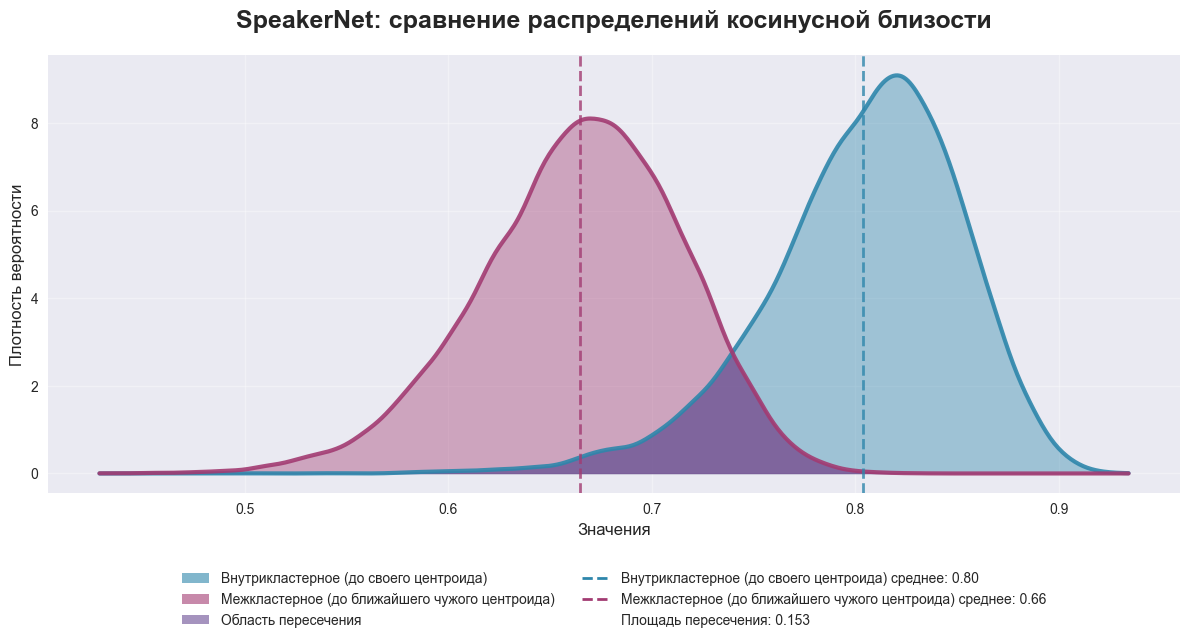

C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



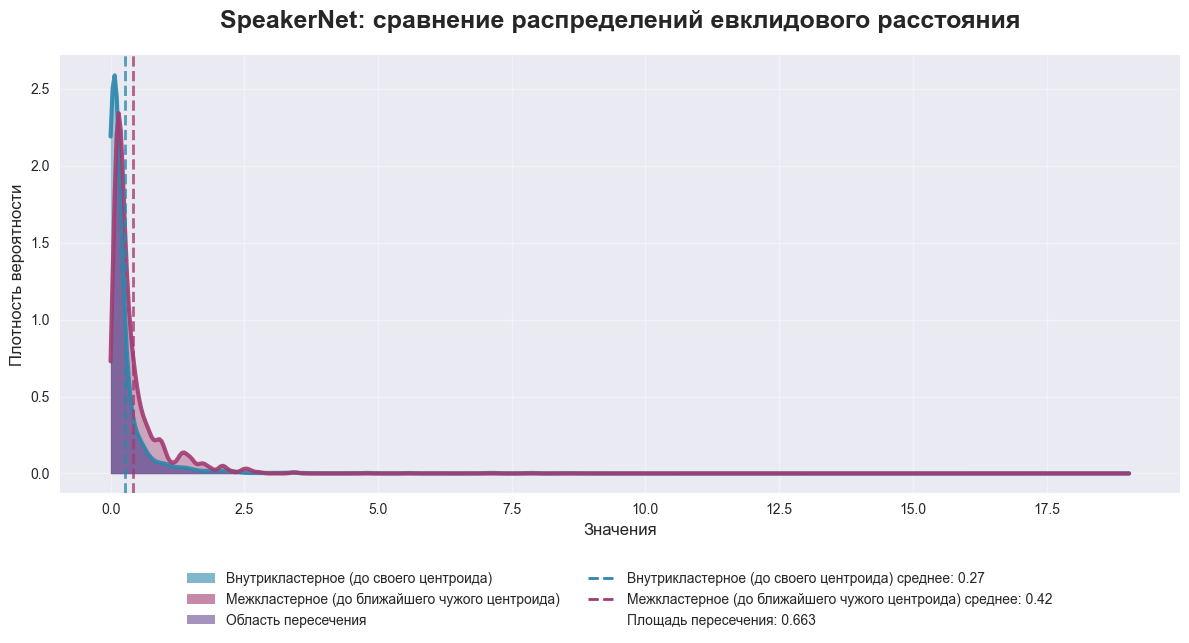

In [10]:
speakernet_emb_path = "embeddings/voxtube-speakernet-embeddings.json"

speakernet_result: Analysis = analyze(speakernet_emb_path, model_name="SpeakerNet")

## 2. TitaNet

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



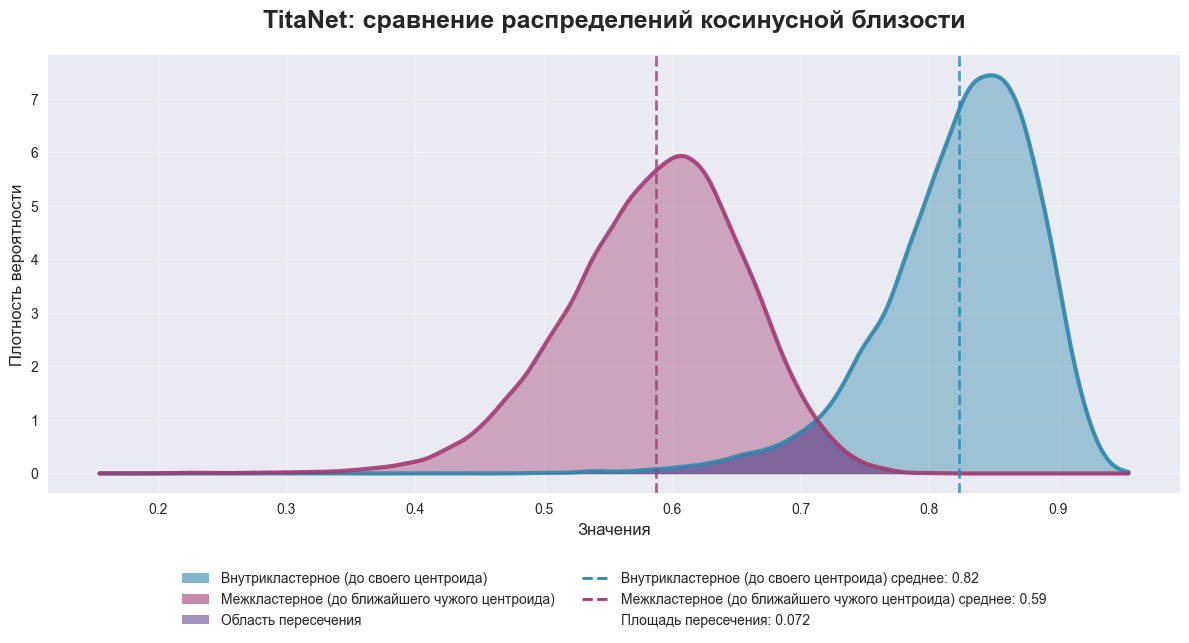

C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



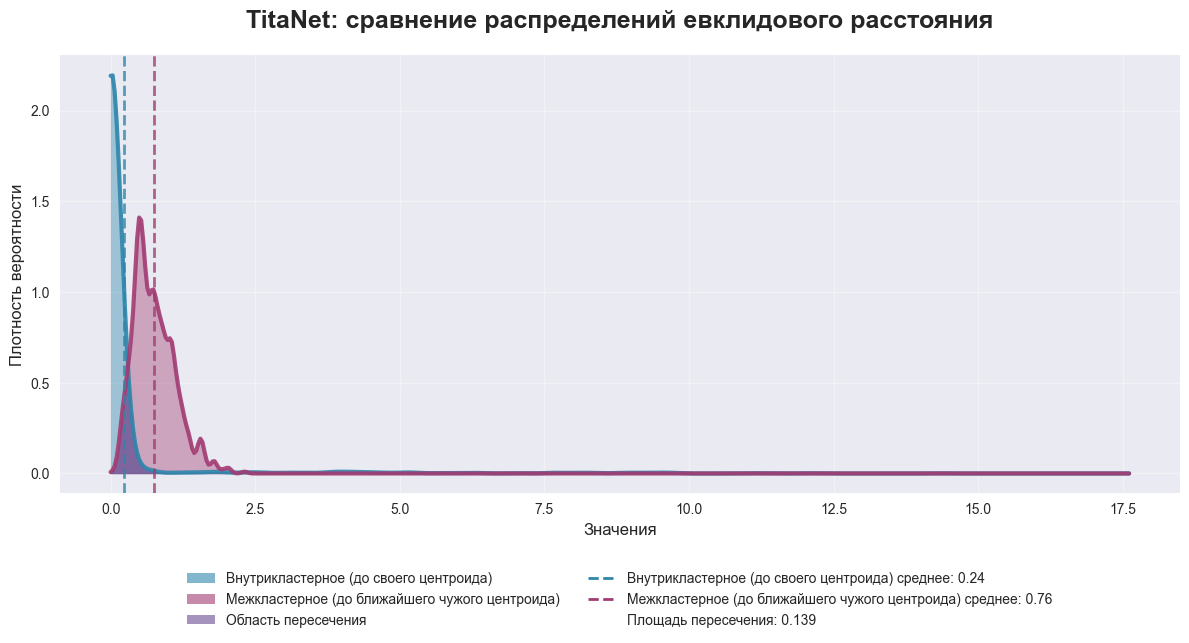

In [13]:
titanet_emb_path = "embeddings/voxtube-titanet-embeddings.json"

titanet_result: Analysis = analyze(titanet_emb_path, model_name="TitaNet")

## 3. PyAnnote-Embedding

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



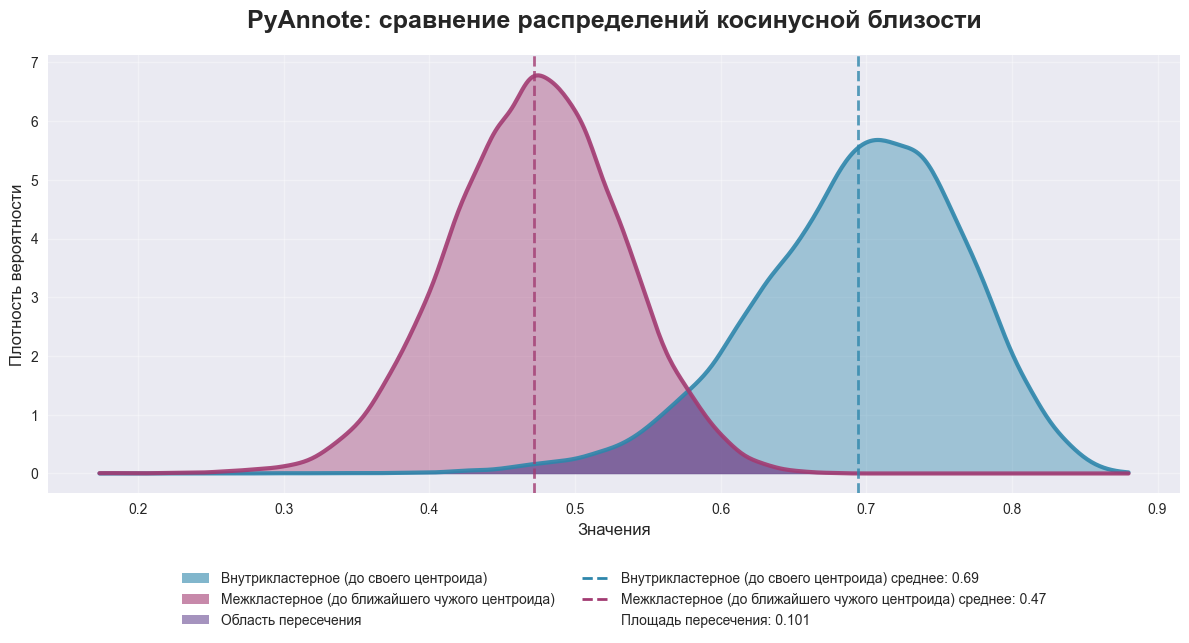

C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



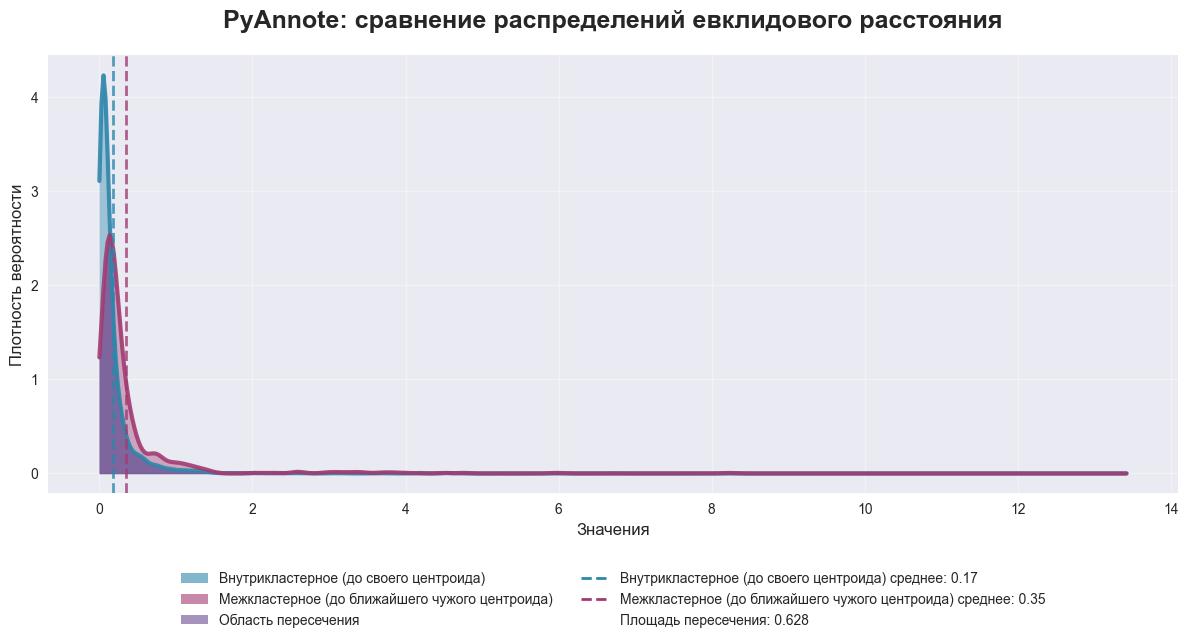

In [14]:
pyannote_emb_path = "embeddings/voxtube-pyannote-embeddings.json"

pyannote_result: Analysis = analyze(pyannote_emb_path, model_name="PyAnnote")

## 4. EcapaTDNN-Nemo

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



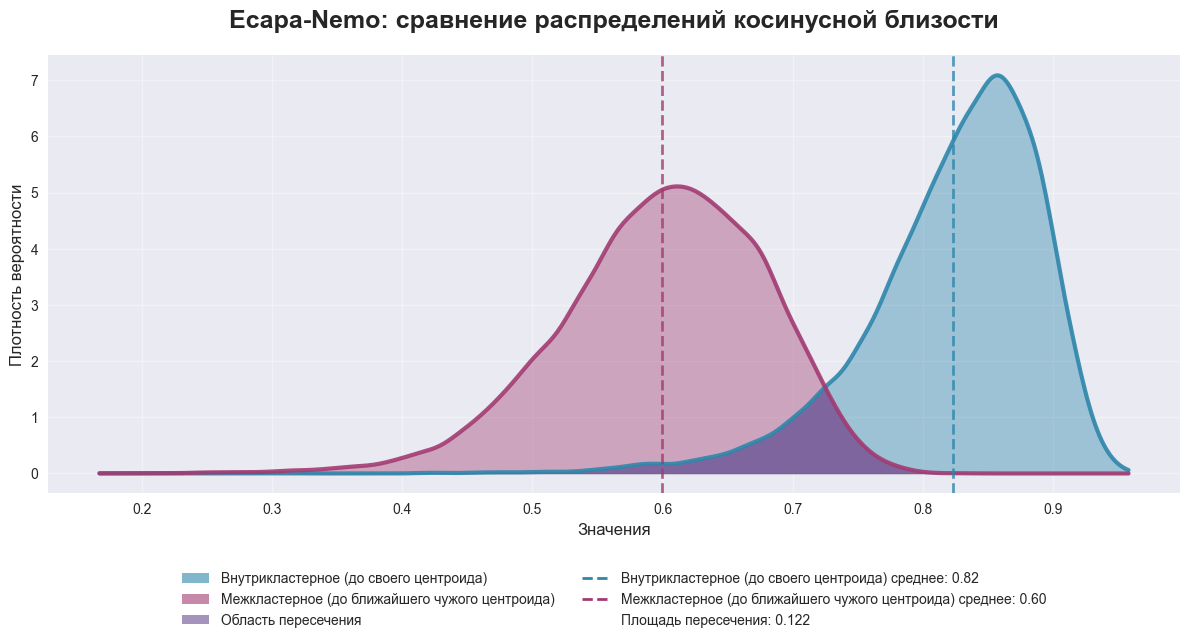

C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



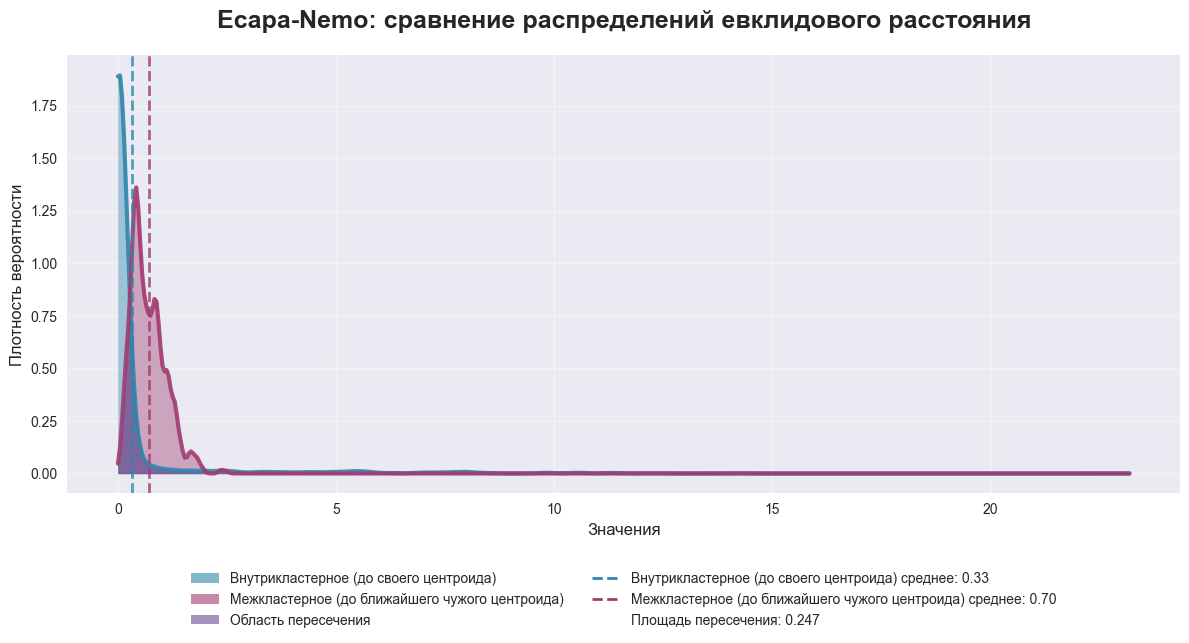

In [15]:
ecapa_nemo_emb_path = "embeddings/voxtube-ecapa-nemo-embeddings.json"

ecapa_nemo_result: Analysis = analyze(ecapa_nemo_emb_path, model_name="Ecapa-Nemo")

## 5. EcapaTDNN-SpeechBrain

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\maksi\miniconda3\envs\diploma-env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



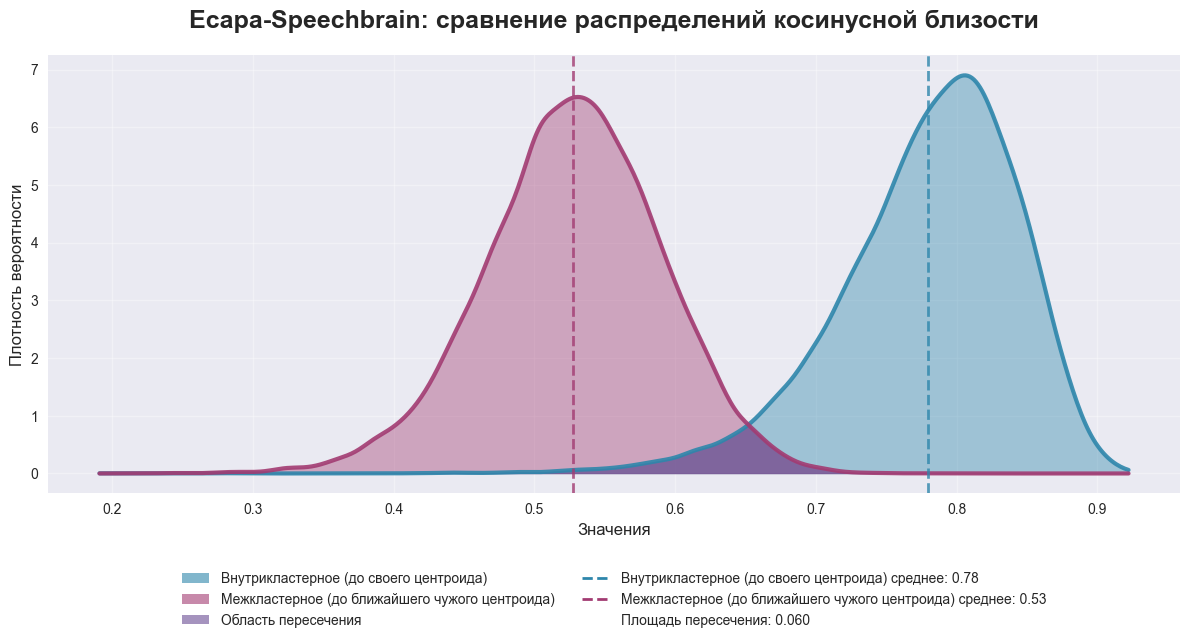

C:\Users\maksi\AppData\Local\Temp\ipykernel_17580\946430565.py:50: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



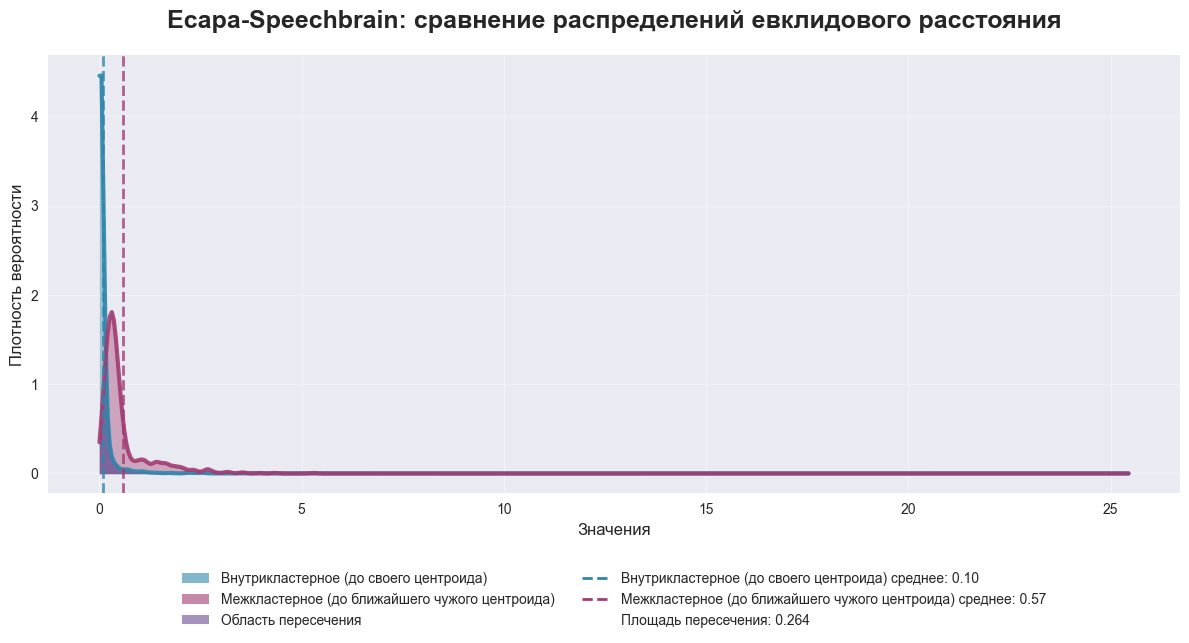

In [16]:
ecapa_emb_path = "embeddings/voxtube-ecapa-embeddings.json"

ecapa_result: Analysis = analyze(ecapa_emb_path, model_name="Ecapa-Speechbrain")

## Собираем всё вместе 

In [17]:
def analysis_to_dict(analysis: Analysis):
    output = dict()

    output["cosine_overlap"] = analysis.cosine_metrics.overlay
    output["cosine_error"] = analysis.cosine_metrics.error
    output["cosine_silhoette"] = analysis.cosine_metrics.silhouette

    output["euclidean_overlap"] = analysis.euclidean_metrics.overlay
    output["euclidean_error"] = analysis.euclidean_metrics.error
    output["euclidean_silhoette"] = analysis.euclidean_metrics.silhouette

    return output

In [18]:
output_df = pd.DataFrame(columns=["cosine_overlap", "cosine_error", "cosine_silhoette", "euclidean_overlap", "euclidean_error", "euclidean_silhoette"])

output_df.loc["SpeakerNet"] = analysis_to_dict(speakernet_result)
output_df.loc["TitaNet"] = analysis_to_dict(titanet_result)
output_df.loc["PyAnnote"] = analysis_to_dict(pyannote_result)
output_df.loc["Ecapa-Nemo"] = analysis_to_dict(ecapa_nemo_result)
output_df.loc["Ecapa-Speechbrain"] = analysis_to_dict(ecapa_result)

In [19]:
output_df.to_csv('./results/result.csv')

In [20]:
output_df

,cosine_overlap,cosine_error,cosine_silhoette,euclidean_overlap,euclidean_error,euclidean_silhoette
SpeakerNet,0.153347,231,0.199892,0.663005,5697,0.330439
TitaNet,0.072388,20,0.341977,0.138527,994,0.857031
PyAnnote,0.101293,55,0.191127,0.627872,6295,0.274814
Ecapa-Nemo,0.121780,48,0.323686,0.246701,1749,0.766812
Ecapa-Speechbrain,0.060105,27,0.300467,0.263984,1566,0.705678
